In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.metrics import *

In [2]:
# load data (source: Kaggle)
data = pd.read_csv("world_real_estate_data.csv")

# data preprocessing
print(data.shape)
print(data.isna().sum())
data.dropna(inplace=True)
print(data.shape)
print(data)

label_encoder = LabelEncoder()
data["Title"] = label_encoder.fit_transform(data["Title"])

(147536, 8)
Title                             0
building_construction_year    82817
building_total_floors         79312
apartment_floor               92944
apartment_rooms               73358
apartment_bathrooms           91563
apartment_area_in_m²           5740
price_in_USD                   2575
dtype: int64
(17631, 8)
                                                    Title  \
6             4 room apartment 245 m² in Yesiloez, Turkey   
15       2 room apartment 54 m² in Prague, Czech Republic   
74      1 room studio apartment 23 m² in Pattaya, Thai...   
88           2 room apartment 92 m² in Karakocali, Turkey   
107          3 room apartment 105 m² in Mahmutlar, Turkey   
...                                                   ...   
147447        2 room apartment 204 m² in Sanur, Indonesia   
147478               1 room apartment 89 m² in Ajman, UAE   
147488          4 room apartment 93 m² in Zagreb, Croatia   
147492  2 room apartment 61 m² in Opcina Kostrena, Cro...   
14752

        Title  building_construction_year  building_total_floors  \
6        3654                      2007.0                    2.0   
15       1771                      2023.0                    4.0   
74       1109                      2021.0                    8.0   
88       2452                      2025.0                   11.0   
107      2596                      2023.0                   12.0   
...       ...                         ...                    ...   
147447   1569                      2024.0                    4.0   
147478   1073                      2023.0                   40.0   
147488   3781                      1910.0                    3.0   
147492   1892                      2023.0                    4.0   
147522   3029                      2025.0                   10.0   

        apartment_floor  apartment_rooms  apartment_bathrooms  \
6                   3.0              5.0                  4.0   
15                  2.0              4.0             

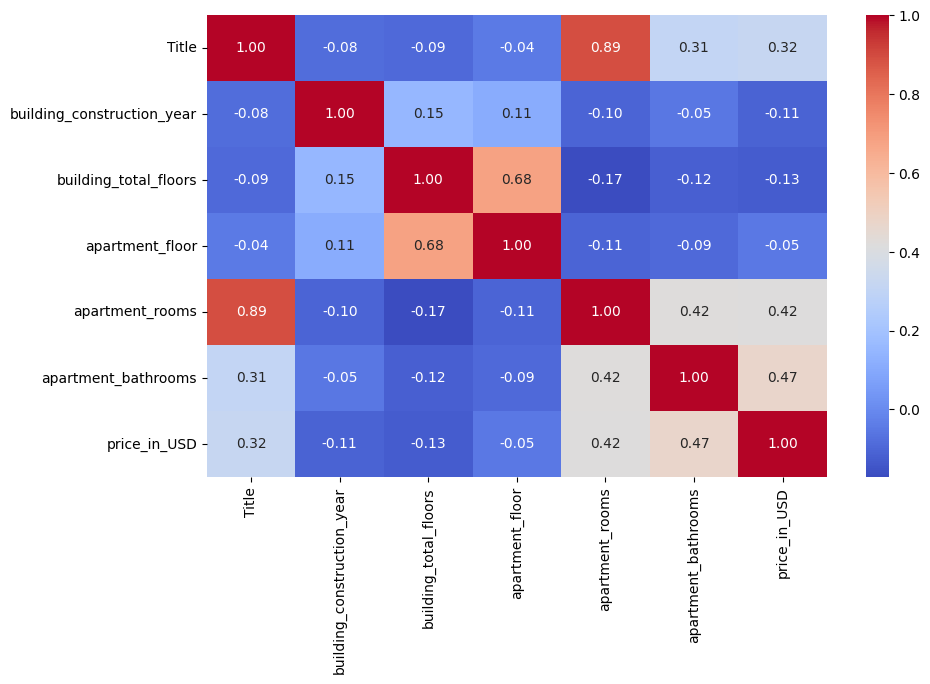

In [3]:
# EDA
print(data)
print(data.describe())

plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [4]:
# Split the dataset into features (X) and target variable (y)
X = data[["building_construction_year", "apartment_floor", "apartment_rooms", "apartment_bathrooms"]]
Y = data["price_in_USD"]

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.18, random_state=2)

In [5]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

R2 score train:  0.7213077364744451
R2 score test:  0.3698663692888595
After hyper-parameter tuning
R2 score train:  0.5431868369255332
R2 score test:  0.4093494547852813
Train MSE:  14054285235.45314
Test MSE:  14054285235.45314
Train MAPE: 0.35238922347914625
Test MAPE: 0.3917645410128736
Train RMSE: 118550.77070796773
Test RMSE: 143153.10577821048
Train MAE: 48084.46096647961
Test MAE: 54089.56205840826
Predicted price: 512871


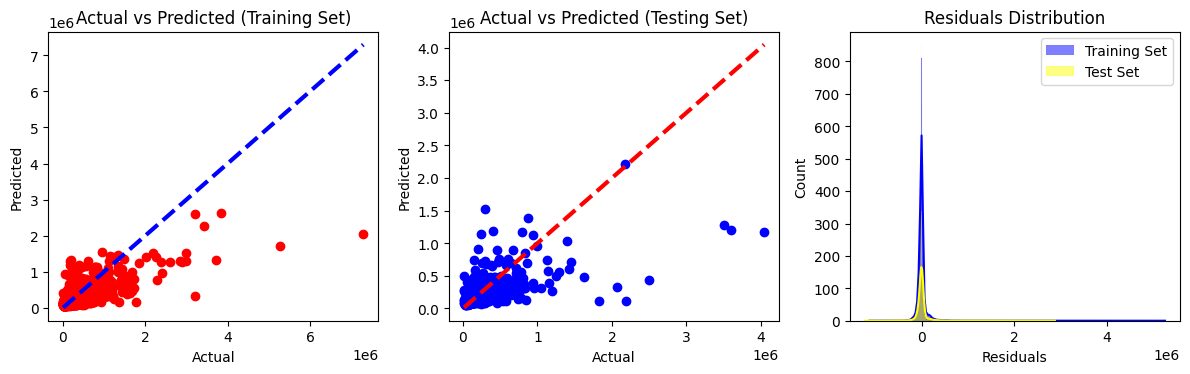

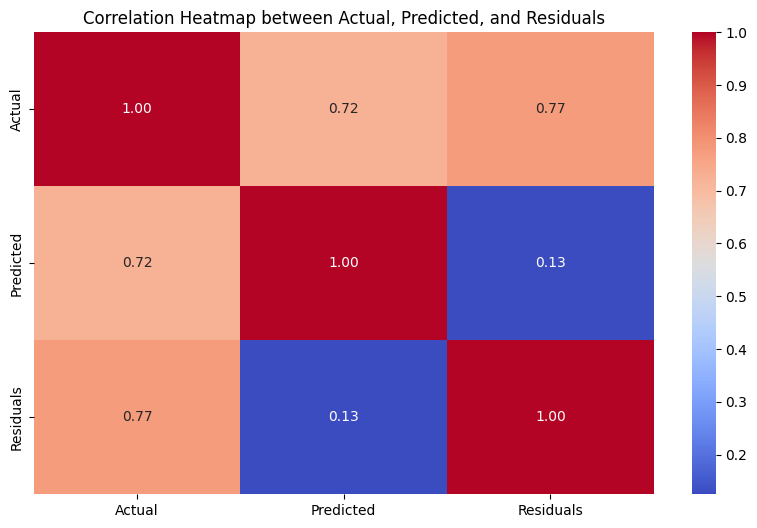

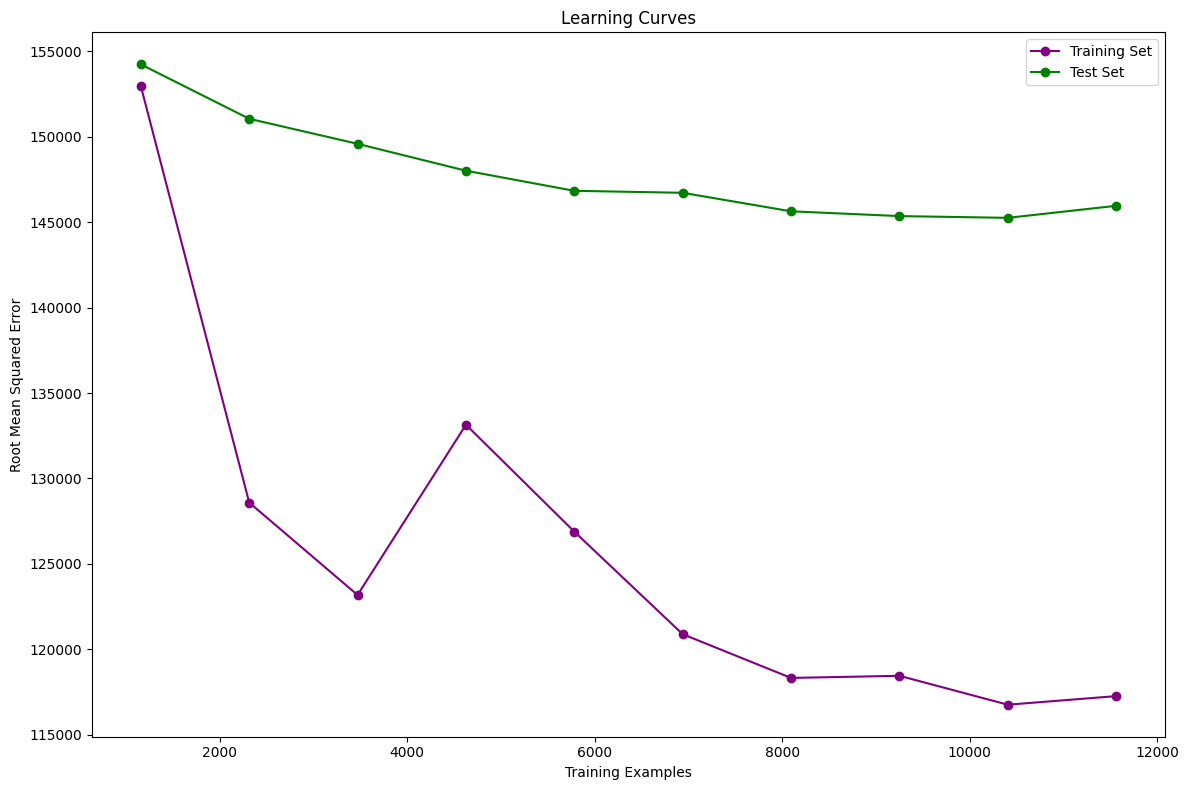

In [6]:
# Random Forest Regression

# Define the Random Forest model
rf = RandomForestRegressor()
rf.fit(X_train_scaled, Y_train)
print("R2 score train: ", r2_score(Y_train, rf.predict(X_train_scaled)))
print("R2 score test: ", r2_score(Y_test, rf.predict(X_test_scaled)))

# Define hyperparameters grid for tuning
param_dist = {
    'n_estimators': [50, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'bootstrap': [True, False]
}

# Perform RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=7, cv=3, scoring='neg_mean_squared_error', random_state=2)
random_search.fit(X_train_scaled, Y_train)

# Get the best parameters
best_params = random_search.best_params_

# Train Random Forest with best parameters
best_rf = RandomForestRegressor(**best_params)
best_rf.fit(X_train_scaled, Y_train)

# Predictions
Y_train_pred = best_rf.predict(X_train_scaled)
Y_test_pred = best_rf.predict(X_test_scaled)

# Evaluate model
print("After hyper-parameter tuning")
print("R2 score train: ", r2_score(Y_train, Y_train_pred))
print("R2 score test: ", r2_score(Y_test, Y_test_pred))
print("Train MSE: ", mean_squared_error(Y_train, Y_train_pred))
print("Test MSE: ", mean_squared_error(Y_train, Y_train_pred))
print("Train MAPE:", mean_absolute_percentage_error(Y_train, Y_train_pred))
print("Test MAPE:", mean_absolute_percentage_error(Y_test, Y_test_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(Y_test, Y_test_pred)))
print("Train MAE:", mean_absolute_error(Y_train, Y_train_pred))
print("Test MAE:", mean_absolute_error(Y_test, Y_test_pred))

new_property = [[2015, 6, 4, 2]]  # Sample new property features
predicted_price = int(best_rf.predict(new_property)[0])
print("Predicted price:", predicted_price)


# Plotting
plt.figure(figsize=(12, 4))

# Plotting actual vs predicted for training set
plt.subplot(1, 3, 1)
plt.scatter(Y_train, Y_train_pred, color="red")
plt.plot([min(Y_train), max(Y_train)], [min(Y_train), max(Y_train)], '--', lw=3, color="blue")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Training Set)')

# Plotting actual vs predicted for testing set
plt.subplot(1, 3, 2)
plt.scatter(Y_test, Y_test_pred, color="blue")
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], '--', lw=3, color="red")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Testing Set)')

# Residuals distribution
residuals_train = Y_train - Y_train_pred
residuals_test = Y_test - Y_test_pred

plt.subplot(1, 3, 3)
sns.histplot(residuals_train, kde=True, color='blue', label='Training Set')
sns.histplot(residuals_test, kde=True, color='yellow', label='Test Set')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.legend()

plt.tight_layout()
plt.show()

# Create a DataFrame with actual, predicted, and residuals for both training and testing sets
results_train = pd.DataFrame({'Actual': Y_train, 'Predicted': Y_train_pred, 'Residuals': residuals_train})
results_test = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_test_pred, 'Residuals': residuals_test})

# Concatenate results from training and testing sets
results = pd.concat([results_train, results_test])

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(results.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Actual, Predicted, and Residuals')
plt.show()

# Learning curves
plt.figure(figsize=(12, 8))
plt.subplot(1, 1, 1)
train_sizes, train_scores, test_scores = learning_curve(best_rf, X_train_scaled, Y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10))
train_rmse_lc = np.sqrt(-train_scores.mean(axis=1))
test_rmse_lc = np.sqrt(-test_scores.mean(axis=1))
plt.plot(train_sizes, train_rmse_lc, 'o-', color='purple', label='Training Set')
plt.plot(train_sizes, test_rmse_lc, 'o-', color='green', label='Test Set')
plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Root Mean Squared Error')
plt.legend()

plt.tight_layout()
plt.show()

R2 score train:  0.7982194006179704
R2 score test:  0.2268594600776117
After hyper-parameter tuning
R2 score train:  0.5585237509468148
R2 score test:  0.4609010001474365
Train MSE:  13582430696.85795
Test MSE:  13582430696.85795
Train MAPE: 0.3466328294734404
Test MAPE: 0.378275239659259
Train RMSE: 116543.68578716717
Test RMSE: 136763.3509199315
Train MAE: 47562.345045308335
Test MAE: 53855.873947990454
Predicted price: 406273


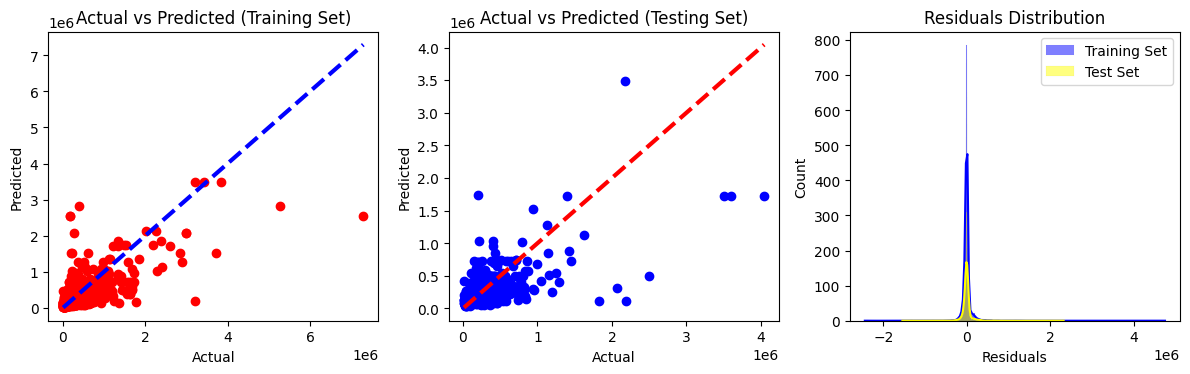

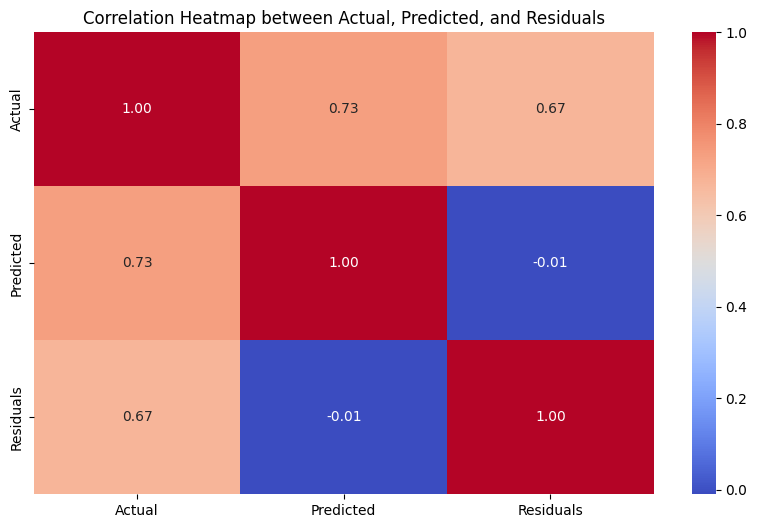

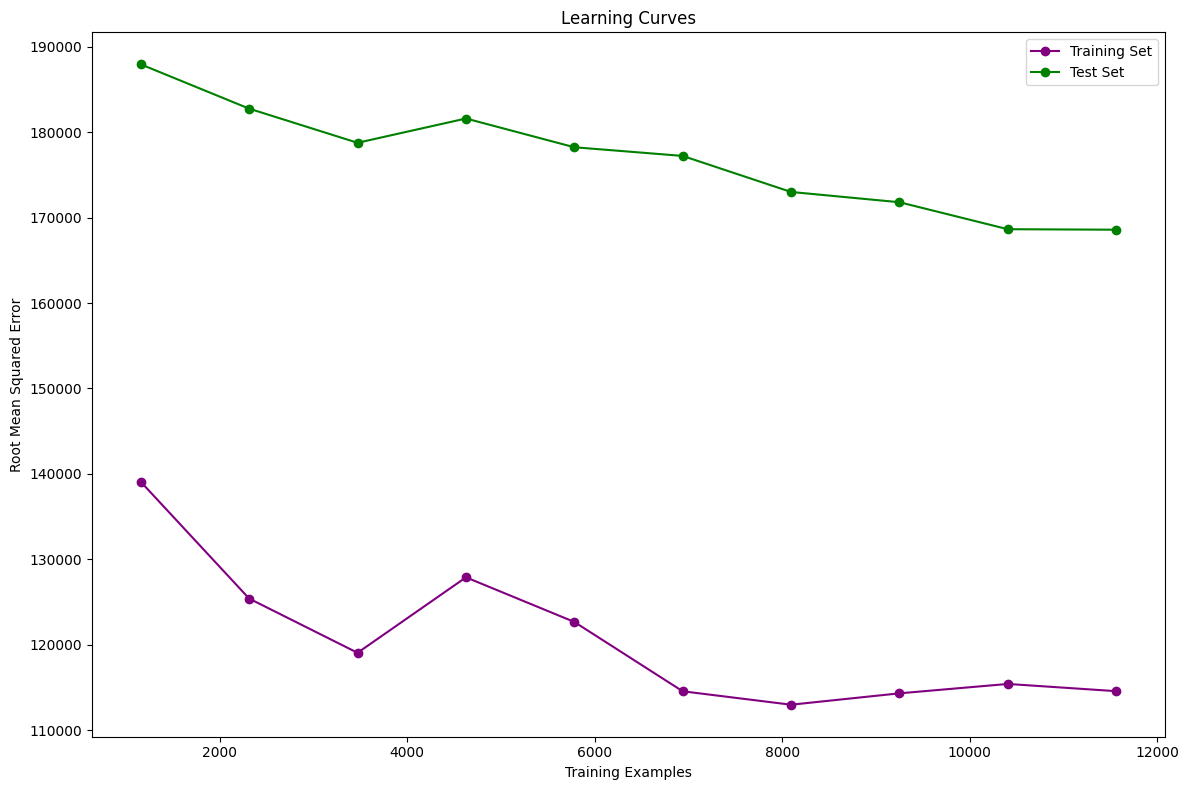

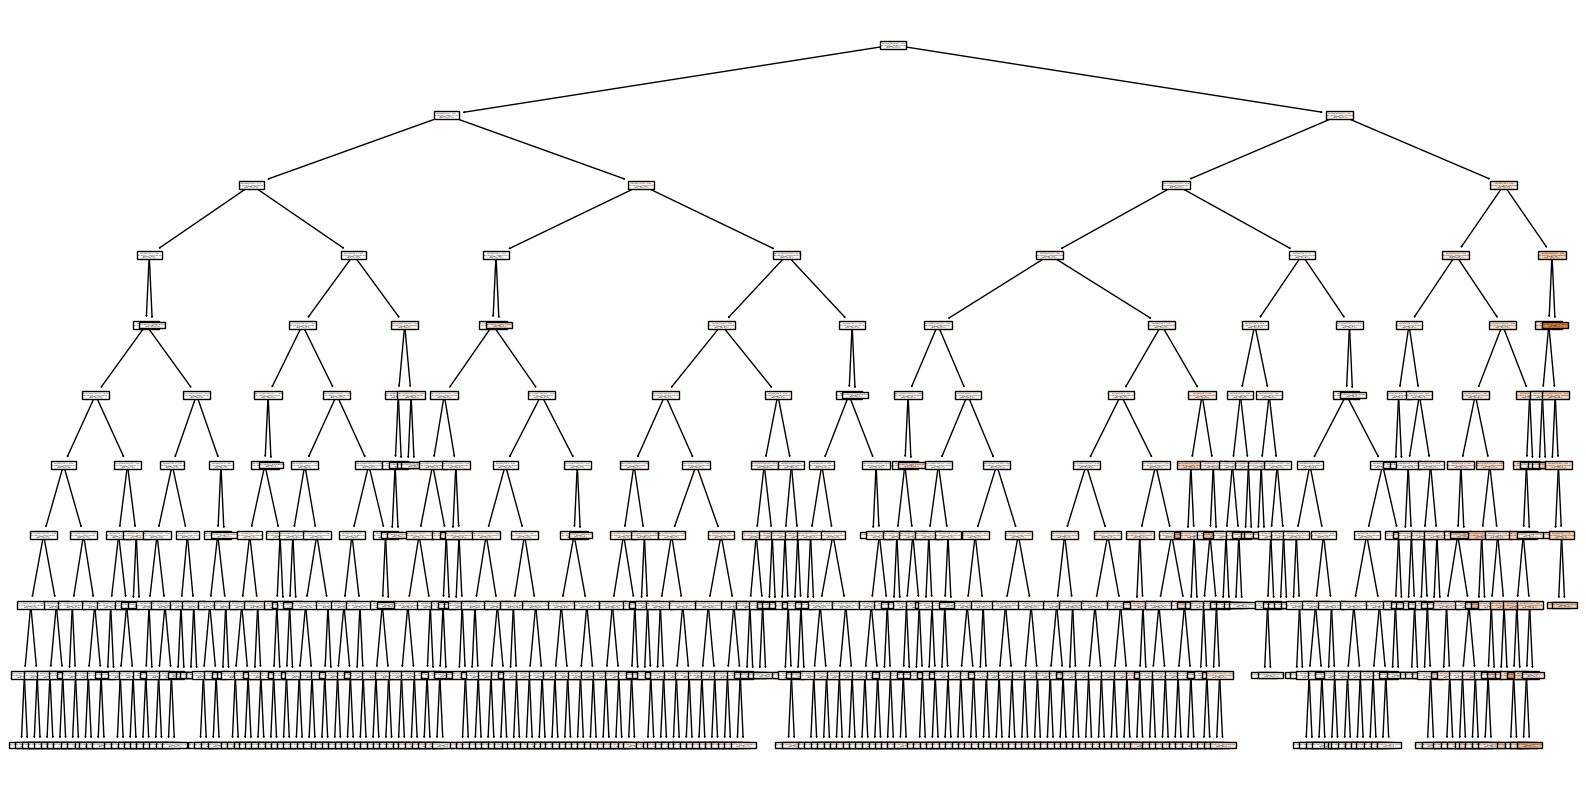

In [7]:
# Decision Tree Regressor

# Define the Decision Tree model
dt = DecisionTreeRegressor()
dt.fit(X_train_scaled, Y_train)
print("R2 score train: ", r2_score(Y_train, dt.predict(X_train_scaled)))
print("R2 score test: ", r2_score(Y_test, dt.predict(X_test_scaled)))

# Define hyperparameters grid for tuning
param_grid = {
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [2]
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, Y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train Decision Tree with best parameters
best_dt = DecisionTreeRegressor(**best_params)
best_dt.fit(X_train_scaled, Y_train)

# Predictions
Y_train_pred = best_dt.predict(X_train_scaled)
Y_test_pred = best_dt.predict(X_test_scaled)

# Evaluate model
print("After hyper-parameter tuning")
print("R2 score train: ", r2_score(Y_train, Y_train_pred))
print("R2 score test: ", r2_score(Y_test, Y_test_pred))
print("Train MSE: ", mean_squared_error(Y_train, Y_train_pred))
print("Test MSE: ", mean_squared_error(Y_train, Y_train_pred))
print("Train MAPE:", mean_absolute_percentage_error(Y_train, Y_train_pred))
print("Test MAPE:", mean_absolute_percentage_error(Y_test, Y_test_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(Y_test, Y_test_pred)))
print("Train MAE:", mean_absolute_error(Y_train, Y_train_pred))
print("Test MAE:", mean_absolute_error(Y_test, Y_test_pred))

new_property = [[2015, 6, 4, 2]]  # Sample new property features
predicted_price = int(best_dt.predict(new_property)[0])
print("Predicted price:", predicted_price)


# Plotting
plt.figure(figsize=(12, 4))

# Plotting actual vs predicted for training set
plt.subplot(1, 3, 1)
plt.scatter(Y_train, Y_train_pred, color='red')
plt.plot([min(Y_train), max(Y_train)], [min(Y_train), max(Y_train)], '--', lw=3, color="blue")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Training Set)')

# Plotting actual vs predicted for testing set
plt.subplot(1, 3, 2)
plt.scatter(Y_test, Y_test_pred, color='blue')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], '--', lw=3, color="red")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Testing Set)')


# Residuals distribution
residuals_train = Y_train - Y_train_pred
residuals_test = Y_test - Y_test_pred

plt.subplot(1, 3, 3)
sns.histplot(residuals_train, kde=True, color='blue', label='Training Set')
sns.histplot(residuals_test, kde=True, color='yellow', label='Test Set')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.legend()

plt.tight_layout()
plt.show()

# Create a DataFrame with actual, predicted, and residuals for both training and testing sets
results_train = pd.DataFrame({'Actual': Y_train, 'Predicted': Y_train_pred, 'Residuals': residuals_train})
results_test = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_test_pred, 'Residuals': residuals_test})

# Concatenate results from training and testing sets
results = pd.concat([results_train, results_test])

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(results.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Actual, Predicted, and Residuals')
plt.show()

# Learning curves
plt.figure(figsize=(12, 8))
plt.subplot(1, 1, 1)
train_sizes, train_scores, test_scores = learning_curve(best_dt, X_train_scaled, Y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10))
train_rmse_lc = np.sqrt(-train_scores.mean(axis=1))
test_rmse_lc = np.sqrt(-test_scores.mean(axis=1))
plt.plot(train_sizes, train_rmse_lc, 'o-', color='purple', label='Training Set')
plt.plot(train_sizes, test_rmse_lc, 'o-', color='green', label='Test Set')
plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Root Mean Squared Error')
plt.legend()

plt.tight_layout()
plt.show()

# Tree visualization
plt.figure(figsize=(20, 10))
plot_tree(best_dt, filled=True, feature_names=X.columns)
plt.show()


Train MSE:  19279483272.026375
Test MSE:  19279483272.026375
Train MAPE: 0.3780668346721542
Test MAPE: 0.415509138300036
Train RMSE: 138850.5789401916
Test RMSE: 147929.22571465652
Train MAE: 53232.00239548861
Test MAE: 57845.33797632076
R2 score train:  0.37334972299274827
R2 score test:  0.36927938223420054
Predicted price: 339062


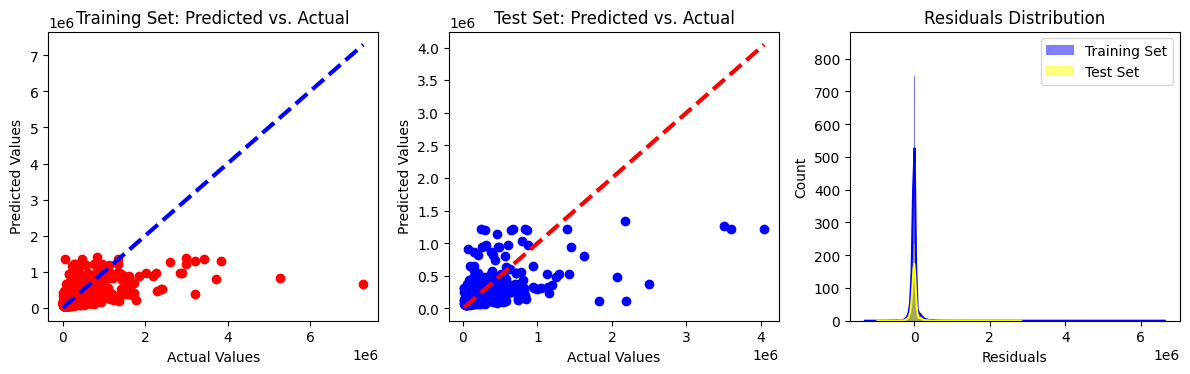

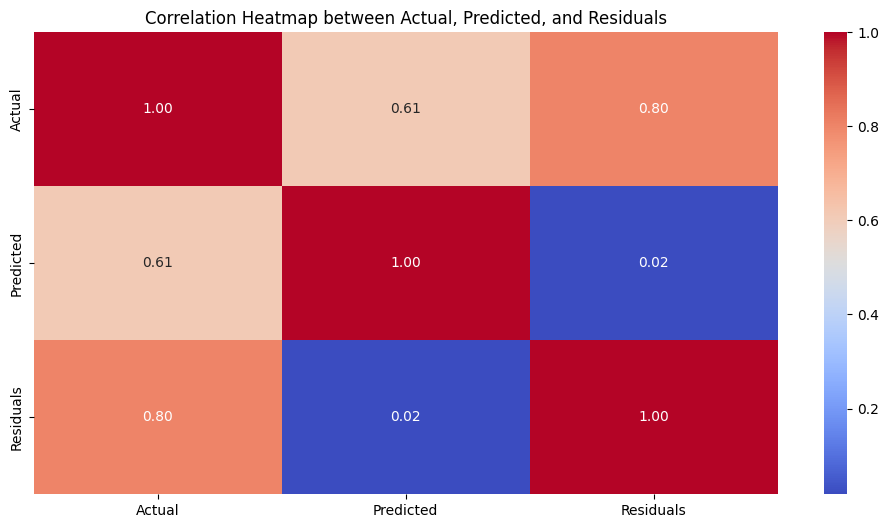

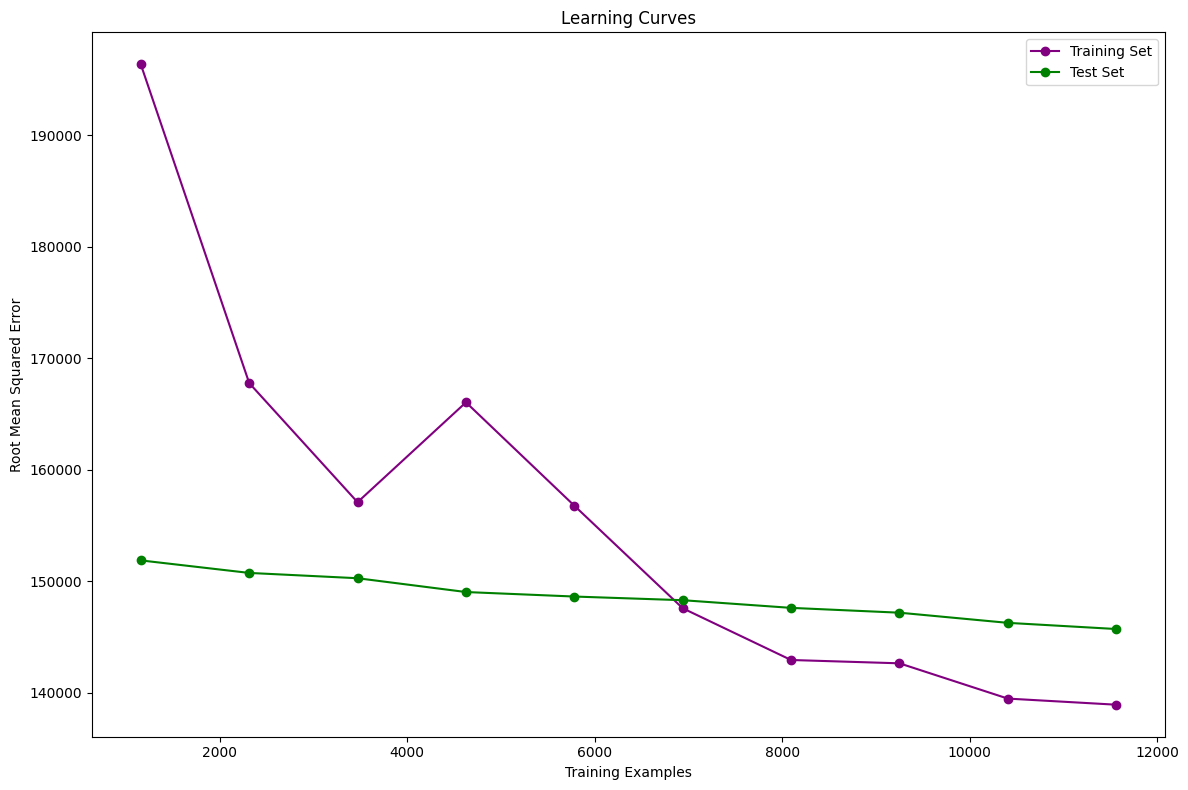

In [8]:
# K-Neighbors Regressor

# Initialize the K-nearest neighbors regressor
knn_regressor = KNeighborsRegressor(n_neighbors=19)

# Training the model
knn_regressor.fit(X_train_scaled, Y_train)

# Predictions
Y_train_pred = knn_regressor.predict(X_train_scaled)
Y_test_pred = knn_regressor.predict(X_test_scaled)

# Calculate RMSE
print("Train MSE: ", mean_squared_error(Y_train, Y_train_pred))
print("Test MSE: ", mean_squared_error(Y_train, Y_train_pred))
print("Train MAPE:", mean_absolute_percentage_error(Y_train, Y_train_pred))
print("Test MAPE:", mean_absolute_percentage_error(Y_test, Y_test_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(Y_test, Y_test_pred)))
print("Train MAE:", mean_absolute_error(Y_train, Y_train_pred))
print("Test MAE:", mean_absolute_error(Y_test, Y_test_pred))
print("R2 score train: ", r2_score(Y_train, Y_train_pred))
print("R2 score test: ", r2_score(Y_test, Y_test_pred))

new_property = [[2015, 6, 4, 2]]  # Sample new property features
predicted_price = int(knn_regressor.predict(new_property)[0])
print("Predicted price:", predicted_price)

# Visualization
plt.figure(figsize=(12, 4))

# Plotting predictions vs. actual for training set
plt.subplot(1, 3, 1)
plt.scatter(Y_train, Y_train_pred, color="red")
plt.plot([min(Y_train), max(Y_train)], [min(Y_train), max(Y_train)], '--', lw=3, color='blue')
plt.title('Training Set: Predicted vs. Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plotting predictions vs. actual for test set
plt.subplot(1, 3, 2)
plt.scatter(Y_test, Y_test_pred, color="blue")
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], '--', lw=3, color='red')
plt.title('Test Set: Predicted vs. Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Residuals distribution
residuals_train = Y_train - Y_train_pred
residuals_test = Y_test - Y_test_pred

plt.subplot(1, 3, 3)
sns.histplot(residuals_train, kde=True, color='blue', label='Training Set')
sns.histplot(residuals_test, kde=True, color='yellow', label='Test Set')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.legend()
plt.tight_layout()
plt.show()

# Create a DataFrame with actual, predicted, and residuals for both training and testing sets
results_train = pd.DataFrame({'Actual': Y_train, 'Predicted': Y_train_pred, 'Residuals': residuals_train})
results_test = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_test_pred, 'Residuals': residuals_test})

# Concatenate results from training and testing sets
results = pd.concat([results_train, results_test])

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(results.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Actual, Predicted, and Residuals')
plt.show()

# Learning curves
plt.figure(figsize=(12, 8))
plt.subplot(1, 1, 1)
train_sizes, train_scores, test_scores = learning_curve(knn_regressor, X_train_scaled, Y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10))
train_rmse_lc = np.sqrt(-train_scores.mean(axis=1))
test_rmse_lc = np.sqrt(-test_scores.mean(axis=1))
plt.plot(train_sizes, train_rmse_lc, 'o-', color='purple', label='Training Set')
plt.plot(train_sizes, test_rmse_lc, 'o-', color='green', label='Test Set')
plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Root Mean Squared Error')
plt.legend()

plt.tight_layout()
plt.show()

Train MSE:  14163640405.424059
Test MSE:  14163640405.424059
Train MAPE: 0.3667288632171759
Test MAPE: 0.3964663600542514
Train RMSE: 119011.09362334278
Test RMSE: 144138.6657328504
Train MAE: 49502.44586520352
Test MAE: 54516.02175020875
R2 score train:  0.5396324134699066
R2 score test:  0.4011886066537361
Predicted price: 573710


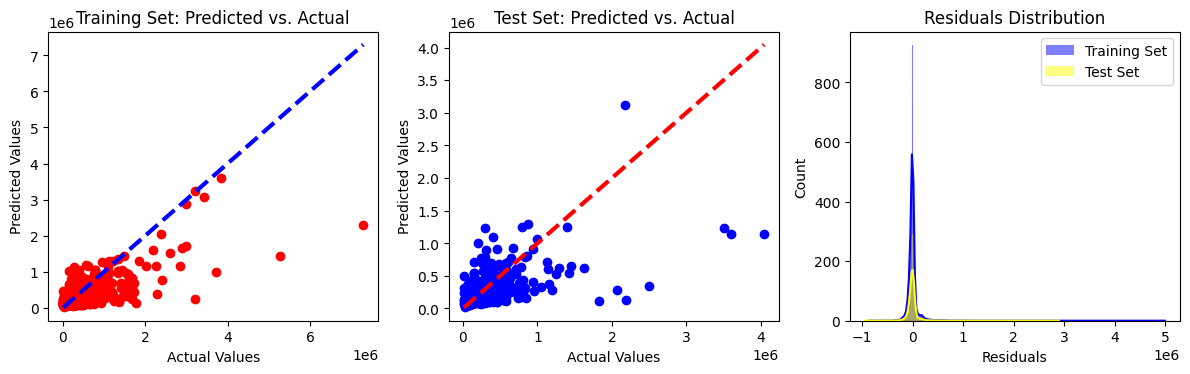

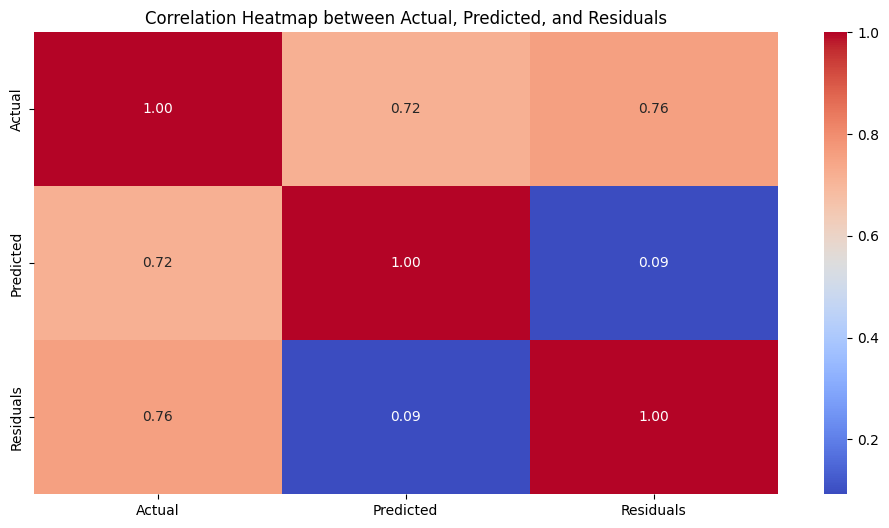

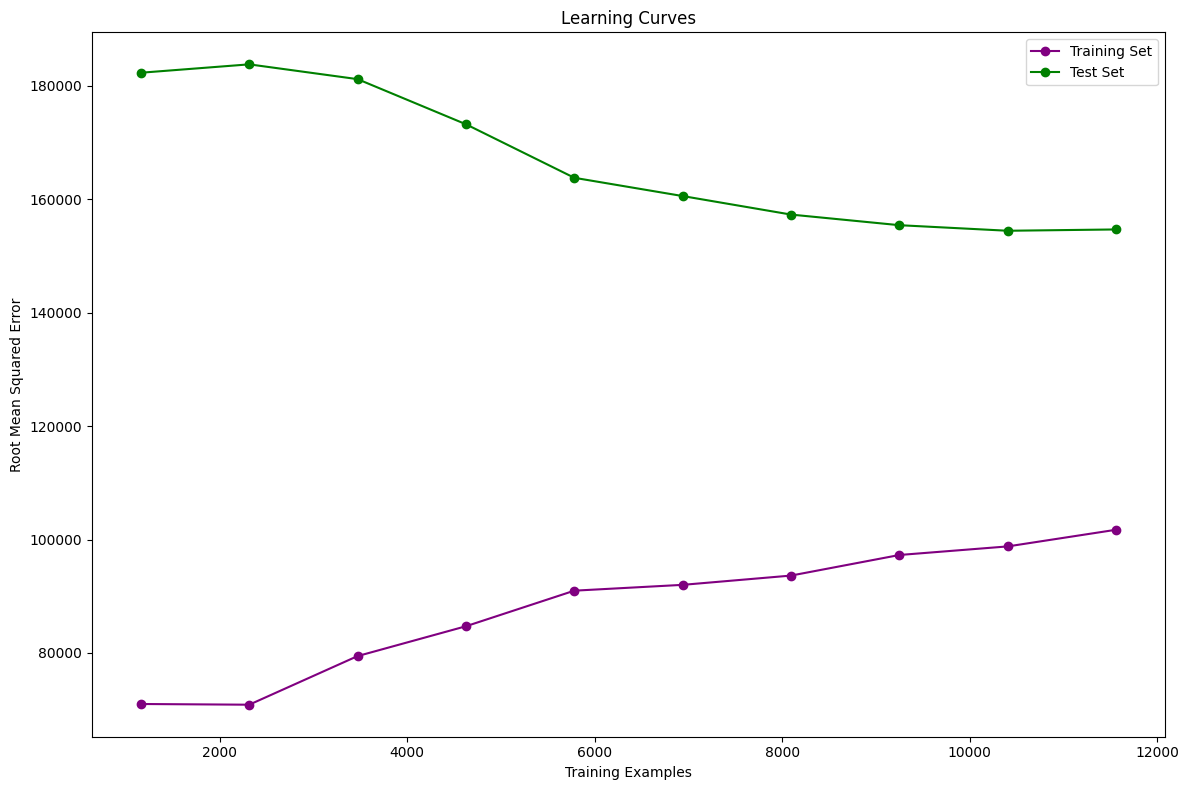

In [9]:
# Initialize CatBoost regressor
catboost_regressor = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, loss_function='RMSE', verbose=0)

# Train the model
catboost_regressor.fit(X_train_scaled, Y_train, eval_set=(X_test_scaled, Y_test), early_stopping_rounds=50)

# Predictions
Y_train_pred = catboost_regressor.predict(X_train_scaled)
Y_test_pred = catboost_regressor.predict(X_test_scaled)

# Calculate RMSE
print("Train MSE: ", mean_squared_error(Y_train, Y_train_pred))
print("Test MSE: ", mean_squared_error(Y_train, Y_train_pred))
print("Train MAPE:", mean_absolute_percentage_error(Y_train, Y_train_pred))
print("Test MAPE:", mean_absolute_percentage_error(Y_test, Y_test_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(Y_test, Y_test_pred)))
print("Train MAE:", mean_absolute_error(Y_train, Y_train_pred))
print("Test MAE:", mean_absolute_error(Y_test, Y_test_pred))
print("R2 score train: ", r2_score(Y_train, Y_train_pred))
print("R2 score test: ", r2_score(Y_test, Y_test_pred))

# Predict price for a new property
new_property = [[2015, 6, 4, 2]]  # Sample new property features
predicted_price = int(catboost_regressor.predict(new_property)[0])
print("Predicted price:", predicted_price)

# Visualization
plt.figure(figsize=(12, 4))

# Plotting predictions vs. actual for training set
plt.subplot(1, 3, 1)
plt.scatter(Y_train, Y_train_pred, color="red")
plt.plot([min(Y_train), max(Y_train)], [min(Y_train), max(Y_train)], '--', lw=3, color='blue')
plt.title('Training Set: Predicted vs. Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plotting predictions vs. actual for test set
plt.subplot(1, 3, 2)
plt.scatter(Y_test, Y_test_pred, color="blue")
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], '--', lw=3, color='red')
plt.title('Test Set: Predicted vs. Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Residuals distribution
residuals_train = Y_train - Y_train_pred
residuals_test = Y_test - Y_test_pred

plt.subplot(1, 3, 3)
sns.histplot(residuals_train, kde=True, color='blue', label='Training Set')
sns.histplot(residuals_test, kde=True, color='yellow', label='Test Set')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.legend()

plt.tight_layout()
plt.show()

# Create a DataFrame with actual, predicted, and residuals for both training and testing sets
results_train = pd.DataFrame({'Actual': Y_train, 'Predicted': Y_train_pred, 'Residuals': residuals_train})
results_test = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_test_pred, 'Residuals': residuals_test})

# Concatenate results from training and testing sets
results = pd.concat([results_train, results_test])

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(results.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Actual, Predicted, and Residuals')
plt.show()

# Learning curves
plt.figure(figsize=(12, 8))
plt.subplot(1, 1, 1)
train_sizes, train_scores, test_scores = learning_curve(catboost_regressor, X_train_scaled, Y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10))
train_rmse_lc = np.sqrt(-train_scores.mean(axis=1))
test_rmse_lc = np.sqrt(-test_scores.mean(axis=1))
plt.plot(train_sizes, train_rmse_lc, 'o-', color='purple', label='Training Set')
plt.plot(train_sizes, test_rmse_lc, 'o-', color='green', label='Test Set')
plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Root Mean Squared Error')
plt.legend()

plt.tight_layout()
plt.show()